In [1]:
import numpy as np
import pickle
from pathlib import Path

DATA_DIR = Path.cwd().parent / 'data'

sessions = np.array([])
for file in sorted(DATA_DIR.glob("steinmetz_part*.npz")):
    print(f"Loading {file}...")
    session = np.load(DATA_DIR / file, allow_pickle=True)
    sessions = np.hstack((sessions, session['dat']))

with open(DATA_DIR / "selectors.npy", "rb") as f:
    selectors = np.load(f, allow_pickle=True)

Loading /home/jovyan/work/data/steinmetz_part0.npz...
Loading /home/jovyan/work/data/steinmetz_part1.npz...
Loading /home/jovyan/work/data/steinmetz_part2.npz...


In [2]:
with open(DATA_DIR / 'decoder_results.pickle', 'rb') as f:
    results = pickle.load(f)

In [26]:
SESSION_NUMBER = 10
SESSION = sessions[SESSION_NUMBER]
RESULTS = results[SESSION_NUMBER]
SELECTOR = selectors[SESSION_NUMBER]

In [27]:
trials = np.array([*set(RESULTS['vision']['trial_numbers']).intersection(RESULTS['action']['trial_numbers'])])
CHOSEN_TRIALS = np.zeros((SESSION['spks'].shape[1]), dtype=bool)
CHOSEN_TRIALS[trials] = True

In [28]:
reaction_times, choices = SESSION['reaction_time'][CHOSEN_TRIALS, :].T
contrasts = SESSION['contrast_right'][CHOSEN_TRIALS]
is_choice_correct = SELECTOR['CHOICE_CORRECT'][CHOSEN_TRIALS]
is_go = ~SELECTOR['CHOICE_NONE'][CHOSEN_TRIALS]

In [29]:
def get_decisions(results, trials):
    idx = np.isin(results['trial_numbers'], trials)
    return results['decisions'][idx], results['decision_times'][idx]

decisions_vision, decision_times_vision = get_decisions(RESULTS['vision'], trials)
decisions_action, decision_times_action = get_decisions(RESULTS['action'], trials)

In [30]:
deliberation_times = decision_times_action - decision_times_vision

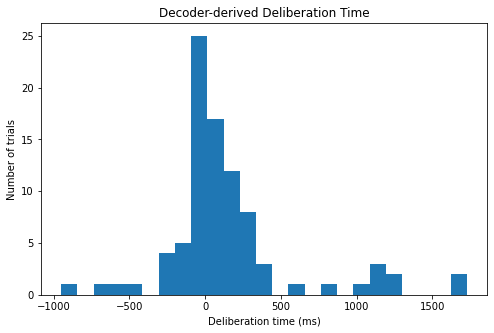

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(8, 5))
plt.hist(deliberation_times[is_go], bins=25)
plt.title("Decoder-derived Deliberation Time")
plt.xlabel("Deliberation time (ms)")
plt.ylabel("Number of trials")
plt.show()

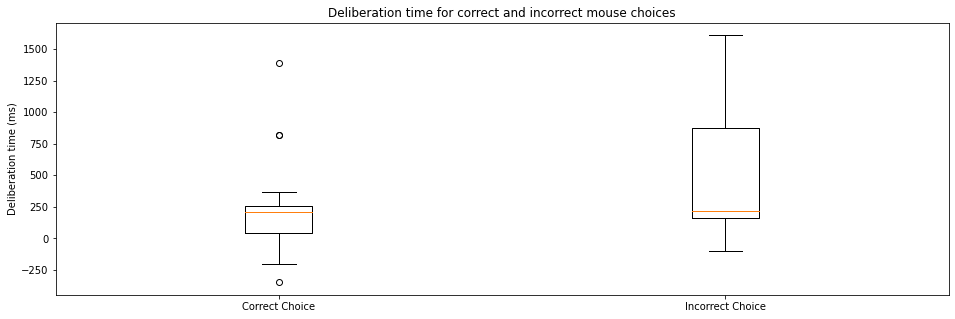

Ttest_indResult(statistic=-2.66063121030212, pvalue=0.012258907245856215)

In [19]:
from scipy.stats import ttest_ind

boxplot_data = np.array(
    [
        deliberation_times[is_go & is_choice_correct],
        deliberation_times[is_go & ~is_choice_correct]
    ],
    dtype=object
)
plt.figure(figsize=(16, 5))
plt.boxplot(boxplot_data, labels=["Correct Choice", "Incorrect Choice"])
plt.title("Deliberation time for correct and incorrect mouse choices")
plt.ylabel("Deliberation time (ms)")
plt.show()

ttest_ind(*boxplot_data, equal_var=False)

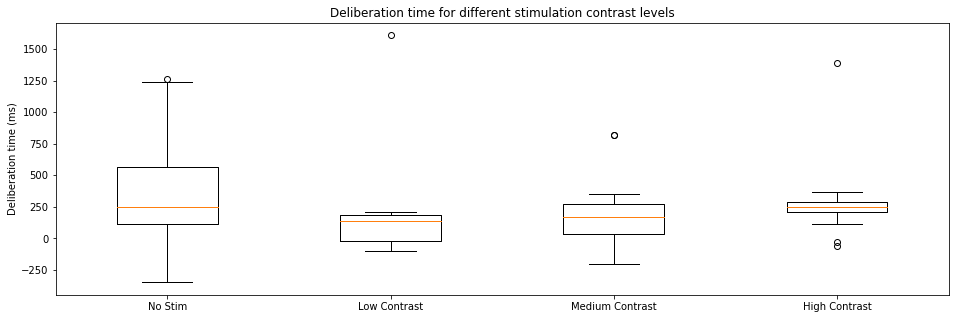

In [20]:
boxplot_data = np.array(
    [
        deliberation_times[is_go & (contrasts == 0)],
        deliberation_times[is_go & (contrasts == 0.25)],
        deliberation_times[is_go & (contrasts == 0.5)],
        deliberation_times[is_go & (contrasts == 1)],
    ],
    dtype=object
)
plt.figure(figsize=(16, 5))
plt.boxplot(boxplot_data, labels=["No Stim", "Low Contrast", "Medium Contrast", "High Contrast"])
plt.title("Deliberation time for different stimulation contrast levels")
plt.ylabel("Deliberation time (ms)")
plt.show()

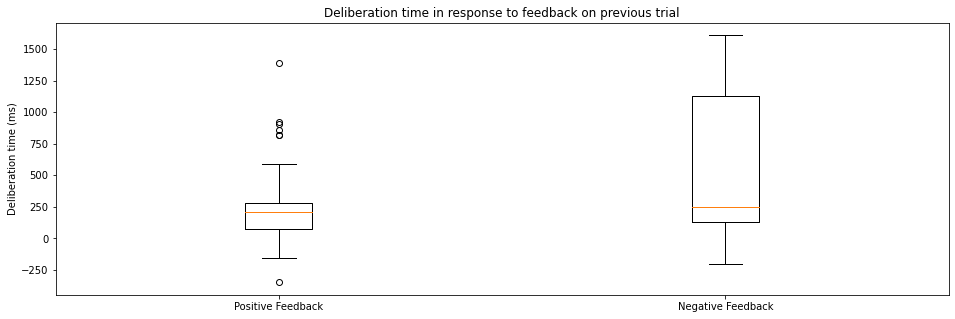

Ttest_indResult(statistic=-1.7020147350173587, pvalue=0.11160267127138612)

In [21]:
feedback = SESSION['feedback_type'][:-1][CHOSEN_TRIALS[1:]]

boxplot_data = np.array(
    [
        deliberation_times[1:][is_go[1:] & (feedback == 1)],
        deliberation_times[1:][is_go[1:] & (feedback == -1)],
    ],
    dtype=object
)
plt.figure(figsize=(16, 5))
plt.boxplot(boxplot_data, labels=["Positive Feedback", "Negative Feedback"])
plt.title("Deliberation time in response to feedback on previous trial")
plt.ylabel("Deliberation time (ms)")
plt.show()

ttest_ind(*boxplot_data, equal_var=False)

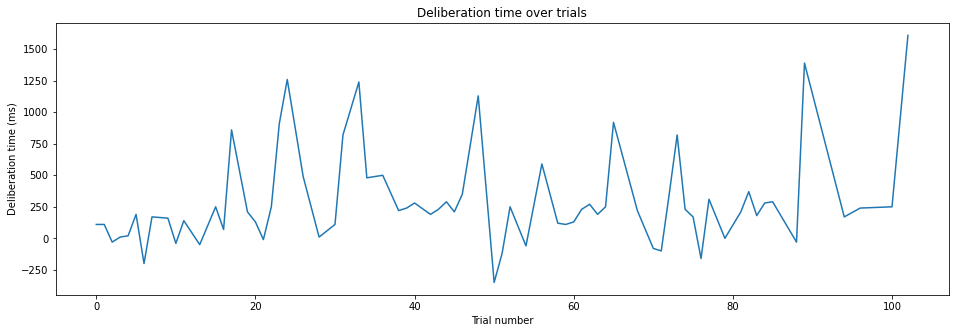

In [22]:
plt.figure(figsize=(16, 5))
plt.plot(trials[is_go], deliberation_times[is_go])
plt.title("Deliberation time over trials")
plt.xlabel("Trial number")
plt.ylabel("Deliberation time (ms)")
plt.show()